# ATL08 and LVIS height comparison:

##### This notebook will 1) read in the ICESat-2 ATL08 (created in ATL08_retrieval.ipynb) and 2019 LVIS L2 file, 2) convert the ATL08 and LVIS data to spatial features, and 3) compare the canopy top height and ground elevation from two datasets at ATL08 segment level (100m * 12m).

##### For LVIS retrieval, please see notebook/1.Reference product/1.2.1 LVIS biomass model over plot.ipynb for details

In [14]:
#install.packages(sp)
#install.packages(ggplot2)
#install.packages(raster)
#install.packages(maptools)
#install.packages("tidyverse")
#install.packages("optparse")
#install.packages("geojsonio")
#install.packages(rgeos)
#install.packages(gstat)
#install.packages(lidR)
#install.packages(sf)
#install.packages(fs)
#install.packages(rgdal)
library(sp)
library(ggplot2)
library(raster)
library(maptools)
library(tidyverse)
library(optparse)
library(geojsonio)
library(rgeos)
library(gstat)
library(sf)
library(fs)
library(rgdal)

In [2]:
#Convert the ATL08 file from the csv format to the point features. Then create ATL08 segments (100m*12m) using each ATL08 coordinates as centroids 
atl08_list <- list.files('/projects/ICESat-2_LVIS/ATL08_csv/',pattern = ".csv",full.names = TRUE)

for(i in 1:length(atl08_list)) {
  if(i==1) {
    atl08_temp <- read.csv(atl08_list[1])
    atl08_temp$filename <- substr(atl08_list[1],1,nchar(atl08_list[1])-9)
    atl08_temp$track_num <- substr(atl08_list[1],73,77)
    atl08_file <- atl08_temp
  }
  if(i>1) {
    atl08_temp <- read.csv(atl08_list[i])
    atl08_temp$filename <- substr(atl08_list[i],1,nchar(atl08_list[i])-9)
    atl08_temp$track_num <- substr(atl08_list[i],73,77)
    atl08_file <- rbind(atl08_file,atl08_temp)
  }
  print(i)
}

#Extract the ATL08 within latitudinal bounds
atl08_file <- atl08_file[which(atl08_file$latitude >= 61.983453 & atl08_file$latitude <= 67.918485),]
write.csv(atl08_file,file = '/projects/ICESat-2_LVIS/ATL08/Intersected_ATL08.csv')

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97


In [21]:
#Convert the ATL08 file to spatial features with coordinates assigned
coordinates(atl08_file) <- c("longitude","latitude")
proj4string(atl08_file) <- CRS("+proj=longlat +datum=WGS84 +no_defs")
atl08_file <- spTransform(atl08_file, CRS("+init=epsg:32606"))

ERROR: Error in `coordinates<-`(`*tmp*`, value = c("longitude", "latitude")): setting coordinates cannot be done on Spatial objects, where they have already been set


In [30]:
#Create ATL08 segment (100m * 12m) as shapefile
atl08_name <- unique(atl08_file$filename)
atl08_track <- unique(atl08_file@data$track_num)

#loop over all the granules and tracks
for(i in 1:length(atl08_name)) {
 for(j in 1:length(atl08_track)) { 
#Check the data availability
if(nrow(atl08_file[which(atl08_file@data$filename == atl08_name[i] & atl08_file$track_num == atl08_track[j]),])>0) {
atl08_file_temp <- atl08_file[which(atl08_file@data$filename == atl08_name[i] & atl08_file$track_num == atl08_track[j]),] 
atl08_file_temp@data$ID <- c(1:nrow(atl08_file_temp@data))
xmin <- atl08_file_temp@bbox[1,1]
xmax <- atl08_file_temp@bbox[1,2]
ymin <- atl08_file_temp@bbox[2,1]
ymax <- atl08_file_temp@bbox[2,2]
n = nrow(atl08_file_temp@coords)
x_diff <- atl08_file_temp@coords[1,1] -atl08_file_temp@coords[n,1]
y_diff <- atl08_file_temp@coords[1,2] -atl08_file_temp@coords[n,2]
#Check the inclination of each track
if(x_diff / y_diff < 0) {
beita <- atan((ymax-ymin)/(xmax-xmin))
atl08_file_temp@data$x_min <- atl08_file_temp@coords[,1] - 50*cos(beita) - 6*sin(beita)
atl08_file_temp@data$x_max2 <- atl08_file_temp@coords[,1] - 50*cos(beita) +  6*sin(beita)
atl08_file_temp@data$x_min2 <- atl08_file_temp@coords[,1] + 50*cos(beita) -  6*sin(beita)
atl08_file_temp@data$x_max <- atl08_file_temp@coords[,1] + 50*cos(beita) + 6*sin(beita)

atl08_file_temp@data$y_min <- atl08_file_temp@coords[,2] - 50*sin(beita) -  6*cos(beita)
atl08_file_temp@data$y_min2 <- atl08_file_temp@coords[,2] - 50*sin(beita) + 6*cos(beita)
atl08_file_temp@data$y_max2 <- atl08_file_temp@coords[,2] + 50*sin(beita) - 6*cos(beita)
atl08_file_temp@data$y_max <- atl08_file_temp@coords[,2] + 50*sin(beita) + 6*cos(beita)

df <- atl08_file_temp@data
ATL08_file_temp_poly <- lapply(1:nrow(df), function(x){
  ## create a matrix of coordinates that also 'close' the polygon
  res <- matrix(c(df[x, 'x_min'], df[x, 'y_max2'],
                  df[x, 'x_min2'], df[x, 'y_min'],
                  df[x, 'x_max'], df[x, 'y_min2'],
                  df[x, 'x_max2'], df[x, 'y_max'],
                  df[x, 'x_min'], df[x, 'y_max2'])  ## need to close the polygon
                , ncol =2, byrow = T
  )
  ## create polygon objects
  st_polygon(list(res))
  
})
ATL08_file_temp_poly <- st_sf(ID = df[, 'ID'], st_sfc(ATL08_file_temp_poly))
ATL08_file_temp_poly<- as(ATL08_file_temp_poly,'Spatial')
crs(ATL08_file_temp_poly) <- "+init=epsg:32606"
ATL08_file_temp_poly@data$Max_Canopy <- atl08_file_temp@data$h_max_canopy
ATL08_file_temp_poly@data$Ground<- atl08_file_temp@data$atl03_ground_median
ATL08_file_temp_poly@data$time <- atl08_file_temp@data$delta_time
ATL08_file_temp_poly@data$slope<- atl08_file_temp@data$terrain_slope
ATL08_file_temp_poly@data$cloud <- atl08_file_temp@data$msw_flag

if(i==1 & j==1) {
  atl08_poly <- ATL08_file_temp_poly
} else {atl08_poly <- bind(ATL08_file_temp_poly,atl08_poly)} }

if(x_diff / y_diff > 0) {
beita <- atan((ymax-ymin)/(xmax-xmin))

atl08_file_temp@data$x_min <- atl08_file_temp@coords[,1] - 50*cos(beita) - 6*cos(pi/2-beita)
atl08_file_temp@data$x_max2 <- atl08_file_temp@coords[,1] - 50*cos(beita) + 6*cos(pi/2-beita)
atl08_file_temp@data$x_min2 <- atl08_file_temp@coords[,1] + 50*cos(beita) - 6*cos(pi/2-beita)
atl08_file_temp@data$x_max <- atl08_file_temp@coords[,1] + 50*cos(beita) + 6*cos(pi/2-beita)

atl08_file_temp@data$y_min <- atl08_file_temp@coords[,2] - 50*sin(beita) - 6*sin(pi/2-beita)
atl08_file_temp@data$y_min2 <- atl08_file_temp@coords[,2] - 50*sin(beita) + 6*sin(pi/2-beita)
atl08_file_temp@data$y_max2 <- atl08_file_temp@coords[,2] + 50*sin(beita) - 6*sin(pi/2-beita)
atl08_file_temp@data$y_max <- atl08_file_temp@coords[,2] + 50*sin(beita) + 6*sin(pi/2-beita)

df <- atl08_file_temp@data
ATL08_file_temp_poly <- lapply(1:nrow(df), function(x){
  res <- matrix(c(df[x, 'x_min'], df[x, 'y_min2'],
                  df[x, 'x_min2'], df[x, 'y_max'],
                  df[x, 'x_max'], df[x, 'y_max2'],
                  df[x, 'x_max2'], df[x, 'y_min'],
                  df[x, 'x_min'], df[x, 'y_min2']) 
                , ncol =2, byrow = T
  )
  st_polygon(list(res))
  
})
ATL08_file_temp_poly <- st_sf(ID = df[, 'ID'], st_sfc(ATL08_file_temp_poly))
ATL08_file_temp_poly<- as(ATL08_file_temp_poly,'Spatial')
crs(ATL08_file_temp_poly) <- "+init=epsg:32606"
ATL08_file_temp_poly@data$Max_Canopy <- atl08_file_temp@data$h_max_canopy
ATL08_file_temp_poly@data$Ground<- atl08_file_temp@data$atl03_ground_median
ATL08_file_temp_poly@data$time <- atl08_file_temp@data$delta_time
ATL08_file_temp_poly@data$slope<- atl08_file_temp@data$terrain_slope
ATL08_file_temp_poly@data$cloud <- atl08_file_temp@data$msw_flag


if(i==1 & j==1) {
  atl08_poly <- ATL08_file_temp_poly
} else {atl08_poly <- bind(ATL08_file_temp_poly,atl08_poly)}}}
 else(print("no data contained"))
print(j)
            }
  print(i) 
}

atl08_poly@data$ID <-  c(1:nrow(atl08_poly@data))

rgdal::writeOGR(obj = atl08_poly,dsn = '/projects/ICESat-2_LVIS/ATL08_Segments/atl08.shp',layer = 'atl08_poly',driver = "ESRI Shapefile")

##Read in ATL08 Shapefile if saved already 
#atl08_poly <- rgdal::readOGR(dsn = '/projects/ICESat-2_LVIS/ATL08_Segments/')

Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 6


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 7


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 8


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 9


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 10


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 11


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1
[1] "no data contained"
[1] 2
[1] "no data contained"
[1] 3
[1] "no data contained"
[1] 4
[1] "no data contained"
[1] 5
[1] "no data contained"
[1] 6
[1] 12


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 13


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 14


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 15


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 16


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 1


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 2


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 3


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 4


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 5


Warning message in showSRID(uprojargs, format = "WKT2", multiline = "YES", prefer_proj = prefer_proj):
“Discarded datum WGS_1984 in Proj4 definition”


[1] 6
[1] 17


In [21]:
#Read in ATL08 file if already saved in a directory
atl08_poly <- rgdal::readOGR(dsn = '/projects/ICESat-2_LVIS/ATL08_Segments/')

OGR data source with driver: ESRI Shapefile 
Source: "/projects/ICESat-2_LVIS/ATL08_Segments", layer: "atl08"
with 309340 features
It has 6 fields


In [42]:
#Use the function from Paul (lvis_metrics.R) to convert LVIS L2 file from txt format to spatial point features
id_cols = c("LFID", "SHOTNUMBER", "TIME", "GLON", "GLAT", "ZG")
t_cols  = c("TLON", "TLAT", "ZT")
h_cols  = c("HLON","HLAT", "ZH")
rh_metrics = c("RH010", "RH015", "RH020", "RH025", "RH030", "RH035", "RH040", "RH045", "RH050", "RH055", "RH060", "RH065", "RH070", "RH075", "RH080", "RH085", "RH090", "RH095", "RH096", "RH097", "RH098", "RH099", "RH100")
misc_cols = c("AZIMUTH", "INCIDENTANGLE", "RANGE", "COMPLEXITY")
channel_cols = c("CHANNEL_ZT", "CHANNEL_ZG", "CHANNEL_RH")
cols <- c(id_cols, h_cols, t_cols, rh_metrics, misc_cols, "SENSITIVITY", channel_cols)
num_lines_hdr=20

load_lvis2 <- function(lvis2_txt_path, num_lines_hdr, cols, crs) {
  
  lvis2_name <- path_ext_remove(path_file(lvis2_txt_path))
  print(paste("Loading", lvis2_name))
  print(paste0("Skipping lines: ", num_lines_hdr))
  lvis2_txt <- read_table2(lvis2_txt_path, skip=num_lines_hdr, col_names=cols)
  print(head(lvis2_txt))
  lvis2_pts <- lvis2_txt %>%
    #dplyr::filter(!is.na(GLON), !is.na(GLAT)) %>%
    st_as_sf(coords=c("GLON","GLAT"), crs=4326) %>%
    st_transform(crs="+proj=utm +zone=06 +datum=WGS84 +units=m +no_defs +ellps=WGS84 +towgs84=0,0,0")
  attr(lvis2_pts, "lvis2_name") <- lvis2_name
  return(lvis2_pts)
}

In [43]:
#Loop over all the LVIS L2 files, extract the footprints overlapped with the ATL08 segments, and combine all
#the intersected footprints in an individual file

lvis_file_list <- list.files('/projects/ICESat-2_LVIS/LVIS_F_L2/',pattern = ".txt",full.names = TRUE)
for(i in 1:length(lvis_file_list)) {

  if(i==1) {
  lvis <- load_lvis2(lvis2_txt_path = lvis_file_list[i],num_lines_hdr = num_lines_hdr,cols = cols)
  #lvis <- sf::as_Spatial(lvis)
  pts_in_poly <- st_join(lvis,atl08, join = st_within)
  join_table_temp <- data.frame(pts_in_poly)
  non_veg_segment <- which(join_table_temp$Max_Canopy > 3.0e+23)
  non_atl08_contained <- which(is.na(join_table_temp$ID)==TRUE)
  join_table_temp <- join_table_temp[-c(non_veg_segment,non_atl08_contained),]
  if(nrow(join_table_temp)>0) {
      join_table <- join_table_temp
  } else {print("No Overlapped Footprint")}
  }
  if(i>1) {
  lvis <- load_lvis2(lvis2_txt_path = lvis_file_list[i],num_lines_hdr = num_lines_hdr,cols = cols)
  pts_in_poly <- st_join(lvis,atl08, join = st_within)
  join_table_temp <- data.frame(pts_in_poly)
  non_veg_segment <- which(join_table_temp$Max_Canopy > 3.0e+23)
  non_atl08_contained <- which(is.na(join_table_temp$ID)==TRUE)
  join_table_temp <- join_table_temp[-c(non_veg_segment,non_atl08_contained),]
   if(nrow(join_table_temp)>0) {
      join_table <- rbind(join_table,join_table_temp)
  } else {print("No Overlapped Footprint")}
  
  }
  print(i)
}

#LVIS_F <- st_buffer(lvis, dist = 5)
#LVIS_F<- sf::as_Spatial(LVIS_F)

[1] "Loading LVISF2_ABoVE2019_0718_R2003_067898"
[1] "Skipping lines: 20"


Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   55208836 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
2 1.96e9   55208837 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
3 1.96e9   55208838 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
4 1.96e9   55208839 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
5 1.96e9   55208840 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
6 1.96e9   55208841 67898.  210.  62.2  676.  210.  62.2  676.  210.  62.2  678.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   55560346 67986.  210.  62.0  617.  210.  62.0  617.  210.  62.0  620.
2 1.96e9   55560347 67986.  210.  62.0  616.  210.  62.0  616.  210.  62.0  622.
3 1.96e9   55560348 67986.  210.  62.0  616.  210.  62.0  626.  210.  62.0  627.
4 1.96e9   55560349 67986.  210.  62.0  617.  210.  62.0  625.  210.  62.0  627.
5 1.96e9   55560350 67986.  210.  62.0  616.  210.  62.0  616.  210.  62.0  620.
6 1.96e9   55560351 67986.  210.  62.0  619.  210.  62.0  619.  210.  62.0  621.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   55910632 68074.  210.  61.8  461.  210.  61.8  461.  210.  61.8  464.
2 1.96e9   55910633 68074.  210.  61.8  461.  210.  61.8  466.  210.  61.8  469.
3 1.96e9   55910634 68074.  210.  61.8  461.  210.  61.8  461.  210.  61.8  466.
4 1.96e9   55910635 68074.  210.  61.8  462.  210.  61.8  474.  210.  61.8  476.
5 1.96e9   55910636 68074.  210.  61.8  461.  210.  61.8  461.  210.  61.8  464.
6 1.96e9   55910637 68074.  210.  61.8  462.  210.  61.8  469.  210.  61.8  471.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   56263042 68162.  210.  61.6  88.8  210.  61.6  109.  210.  61.6  111.
2 1.96e9   56263043 68162.  210.  61.6  89.0  210.  61.6  109.  210.  61.6  111.
3 1.96e9   56263044 68162.  210.  61.6  88.9  210.  61.6  110.  210.  61.6  112.
4 1.96e9   56263045 68162.  210.  61.6  89.1  210.  61.6  109.  210.  61.6  112.
5 1.96e9   56263046 68162.  210.  61.6  89.2  210.  61.6  108.  210.  61.6  111.
6 1.96e9   56263047 68162.  210.  61.6  89.2  210.  61.6  109.  210.  61.6  111.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   56627218 68253.  210.  61.4  31.3  210.  61.4  31.3  210.  61.4  33.2
2 1.96e9   56627219 68253.  210.  61.4  31.4  210.  61.4  31.4  210.  61.4  33.2
3 1.96e9   56627220 68253.  210.  61.4  31.4  210.  61.4  31.4  210.  61.4  33.2
4 1.96e9   56627221 68253.  210.  61.4  31.3  210.  61.4  31.3  210.  61.4  33.2
5 1.96e9   56627222 68253.  210.  61.4  31.4  210.  61.4  31.4  210.  61.4  33.2
6 1.96e9   56627223 68253.  210.  61.4  31.4  210.  61.4  31.4  210.  61.4  33.2
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   56984479 68342.  210.  61.2  10.6  210.  61.2  10.6  210.  61.2  12.1
2 1.96e9   56984480 68342.  210.  61.2  10.5  210.  61.2  10.5  210.  61.2  12  
3 1.96e9   56984481 68342.  210.  61.2  10.5  210.  61.2  10.5  210.  61.2  12.0
4 1.96e9   56984482 68342.  210.  61.2  10.6  210.  61.2  10.6  210.  61.2  12.0
5 1.96e9   56984483 68342.  210.  61.2  10.4  210.  61.2  10.4  210.  61.2  12.0
6 1.96e9   56984484 68342.  210.  61.2  10.5  210.  61.2  10.5  210.  61.2  11.9
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   57460636 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.2
2 1.96e9   57460637 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.3
3 1.96e9   57460638 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.3
4 1.96e9   57460639 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.2
5 1.96e9   57460640 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.2
6 1.96e9   57460641 68461.  210.  61.0  10.7  210.  61.0  10.7  210.  61.0  12.2
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   57812828 68549.  210.  60.8  169.  210.  60.8  174.  210.  60.8  175.
2 1.96e9   57812829 68549.  210.  60.8  169.  210.  60.8  174.  210.  60.8  176.
3 1.96e9   57812830 68549.  210.  60.8  170.  210.  60.8  172.  210.  60.8  176.
4 1.96e9   57812831 68549.  210.  60.8  170.  210.  60.8  170.  210.  60.8  175.
5 1.96e9   57812832 68549.  210.  60.8  170.  210.  60.8  172.  210.  60.8  175.
6 1.96e9   57812833 68549.  210.  60.8  170.  210.  60.8  177.  210.  60.8  180.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   58164982 68637.  210.  60.6  360.  210.  60.6  366.  210.  60.6  367.
2 1.96e9   58164983 68637.  210.  60.6  357.  210.  60.6  364.  210.  60.6  366.
3 1.96e9   58164984 68637.  210.  60.6  359.  210.  60.6  369.  210.  60.6  370.
4 1.96e9   58164985 68637.  210.  60.6  360.  210.  60.6  375.  210.  60.6  376.
5 1.96e9   58164986 68637.  210.  60.6  357.  210.  60.6  357.  210.  60.6  362.
6 1.96e9   58164987 68637.  210.  60.6  358.  210.  60.6  362.  210.  60.6  366.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   22751731 67284.  211.  63.3  769.  211.  63.3  769.  211.  63.3  771.
2 1.96e9   22751732 67284.  211.  63.3  770.  211.  63.3  770.  211.  63.3  772.
3 1.96e9   22751733 67284.  211.  63.3  769.  211.  63.3  769.  211.  63.3  771.
4 1.96e9   22751734 67284.  211.  63.3  769.  211.  63.3  769.  211.  63.3  772.
5 1.96e9   22751735 67284.  211.  63.3  769.  211.  63.3  769.  211.  63.3  772.
6 1.96e9   22751736 67284.  211.  63.3  770.  211.  63.3  770.  211.  63.3  772.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   23113991 67375.  211.  63.5 1210.  211.  63.5 1210.  211.  63.5 1213.
2 1.96e9   23113992 67375.  211.  63.5 1214.  211.  63.5 1214.  211.  63.5 1217.
3 1.96e9   23113993 67375.  211.  63.5 1218   211.  63.5 1219.  211.  63.5 1221.
4 1.96e9   23113994 67375.  211.  63.5 1218.  211.  63.5 1218.  211.  63.5 1221.
5 1.96e9   23113995 67375.  211.  63.5 1221.  211.  63.5 1221.  211.  63.5 1225.
6 1.96e9   23113996 67375.  211.  63.5 1226.  211.  63.5 1226.  211.  63.5 1229.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   23476753 67466.  211.  63.7  845.  211.  63.7  845.  211.  63.7  847.
2 1.96e9   23476754 67466.  211.  63.7  846.  211.  63.7  847.  211.  63.7  851.
3 1.96e9   23476755 67466.  211.  63.7  845.  211.  63.7  845.  211.  63.7  847.
4 1.96e9   23476756 67466.  211.  63.7  845.  211.  63.7  845.  211.  63.7  847.
5 1.96e9   23476757 67466.  211.  63.7  851.  211.  63.7  851.  211.  63.7  854.
6 1.96e9   23476758 67466.  211.  63.7  847.  211.  63.7  847.  211.  63.7  850.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   23826959 67553.  211.  63.9  654.  211.  63.9  658.  211.  63.9  659.
2 1.96e9   23826960 67553.  211.  63.9  654.  211.  63.9  654.  211.  63.9  656.
3 1.96e9   23826961 67553.  211.  63.9  654.  211.  63.9  654.  211.  63.9  657.
4 1.96e9   23826962 67553.  211.  63.9  654.  211.  63.9  654.  211.  63.9  656.
5 1.96e9   23826963 67553.  211.  63.9  654.  211.  63.9  654.  211.  63.9  656.
6 1.96e9   23826964 67553.  211.  63.9  654.  211.  63.9  654.  211.  63.9  658.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   24177088 67641.  211.  64.1  284.  211.  64.1  296.  211.  64.1  303.
2 1.96e9   24177089 67641.  211.  64.1  284.  211.  64.1  284.  211.  64.1  288.
3 1.96e9   24177090 67641.  211.  64.1  284.  211.  64.1  302.  211.  64.1  303.
4 1.96e9   24177091 67641.  211.  64.1  284.  211.  64.1  307.  211.  64.1  308.
5 1.96e9   24177092 67641.  211.  64.1  284.  211.  64.1  301.  211.  64.1  303.
6 1.96e9   24177093 67641.  211.  64.1  284.  211.  64.1  294.  211.  64.1  297.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   24528079 67729.  211.  64.3  194.  211.  64.3  194.  211.  64.3  196.
2 1.96e9   24528080 67729.  211.  64.3  194.  211.  64.3  194.  211.  64.3  196.
3 1.96e9   24528081 67729.  211.  64.3  194.  211.  64.3  197.  211.  64.3  199.
4 1.96e9   24528082 67729.  211.  64.3  194.  211.  64.3  196.  211.  64.3  198.
5 1.96e9   24528083 67729.  211.  64.3  194.  211.  64.3  194.  211.  64.3  197.
6 1.96e9   24528084 67729.  211.  64.3  198.  211.  64.3  198.  211.  64.3  200.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   24879606 67816.  211.  64.5  131.  211.  64.5  131.  211.  64.5  133.
2 1.96e9   24879607 67816.  211.  64.5  131.  211.  64.5  131.  211.  64.5  133.
3 1.96e9   24879608 67816.  211.  64.5  132.  211.  64.5  132.  211.  64.5  136.
4 1.96e9   24879609 67816.  211.  64.5  131.  211.  64.5  138.  211.  64.5  139.
5 1.96e9   24879610 67816.  211.  64.5  131.  211.  64.5  131.  211.  64.5  133.
6 1.96e9   24879611 67816.  211.  64.5  132.  211.  64.5  132.  211.  64.5  137.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   25232348 67905.  211.  64.7  114.  211.  64.7  118.  211.  64.7  119.
2 1.96e9   25232349 67905.  211.  64.7  114.  211.  64.7  114.  211.  64.7  117.
3 1.96e9   25232350 67905.  211.  64.7  114   211.  64.7  114   211.  64.7  117.
4 1.96e9   25232351 67905.  211.  64.7  114.  211.  64.7  114.  211.  64.7  120.
5 1.96e9   25232352 67905.  211.  64.7  114.  211.  64.7  114.  211.  64.7  119.
6 1.96e9   25232353 67905.  211.  64.7  114.  211.  64.7  114.  211.  64.7  117.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   25590846 67994.  211.  64.9  108.  211.  64.9  115.  211.  64.9  117.
2 1.96e9   25590847 67994.  211.  64.9  108.  211.  64.9  117.  211.  64.9  119.
3 1.96e9   25590848 67994.  211.  64.9  109.  211.  64.9  114.  211.  64.9  116.
4 1.96e9   25590849 67994.  211.  64.9  108.  211.  64.9  117.  211.  64.9  119.
5 1.96e9   25590850 67994.  211.  64.9  108.  211.  64.9  108.  211.  64.9  112.
6 1.96e9   25590851 67994.  211.  64.9  108.  211.  64.9  111.  211.  64.9  114.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   25965838 68088.  211.  65.1  105.  211.  65.1  111.  211.  65.1  113.
2 1.96e9   25965839 68088.  211.  65.1  105   211.  65.1  105   211.  65.1  107.
3 1.96e9   25965840 68088.  211.  65.1  105.  211.  65.1  105.  211.  65.1  107.
4 1.96e9   25965841 68088.  211.  65.1  105.  211.  65.1  105.  211.  65.1  108.
5 1.96e9   25965842 68088.  211.  65.1  105.  211.  65.1  105.  211.  65.1  107.
6 1.96e9   25965843 68088.  211.  65.1  105.  211.  65.1  105.  211.  65.1  107.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   26327599 68178.  211.  65.3  519.  211.  65.3  521.  211.  65.3  524.
2 1.96e9   26327600 68178.  211.  65.3  515.  211.  65.3  515.  211.  65.3  519.
3 1.96e9   26327601 68178.  211.  65.3  516.  211.  65.3  516.  211.  65.3  521.
4 1.96e9   26327602 68178.  211.  65.3  518.  211.  65.3  520.  211.  65.3  522.
5 1.96e9   26327603 68178.  211.  65.3  515.  211.  65.3  515.  211.  65.3  520.
6 1.96e9   26327604 68178.  211.  65.3  515.  211.  65.3  517.  211.  65.3  520.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   26677618 68266.  211.  65.4  440.  211.  65.4  440.  211.  65.4  442.
2 1.96e9   26677619 68266.  211.  65.4  441.  211.  65.4  441.  211.  65.4  443.
3 1.96e9   26677620 68266.  211.  65.4  440.  211.  65.4  440.  211.  65.4  442.
4 1.96e9   26677621 68266.  211.  65.4  439.  211.  65.4  439.  211.  65.4  441.
5 1.96e9   26677622 68266.  211.  65.4  440.  211.  65.4  440.  211.  65.4  442.
6 1.96e9   26677623 68266.  211.  65.4  439.  211.  65.4  439.  211.  65.4  441.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   27027925 68353.  211.  65.6  359.  211.  65.6  359.  211.  65.6  362.
2 1.96e9   27027926 68353.  211.  65.6  360.  211.  65.6  360.  211.  65.6  362.
3 1.96e9   27027927 68353.  211.  65.6  359.  211.  65.6  359.  211.  65.6  362.
4 1.96e9   27027928 68353.  211.  65.6  358.  211.  65.6  358.  211.  65.6  361.
5 1.96e9   27027929 68353.  211.  65.6  359   211.  65.6  359   211.  65.6  361.
6 1.96e9   27027930 68353.  211.  65.6  359.  211.  65.6  359.  211.  65.6  361.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   27378417 68441.  211.  65.8  413.  211.  65.8  413.  211.  65.8  416.
2 1.96e9   27378418 68441.  211.  65.8  413.  211.  65.8  413.  211.  65.8  417.
3 1.96e9   27378419 68441.  211.  65.8  412.  211.  65.8  412.  211.  65.8  414.
4 1.96e9   27378420 68441.  211.  65.8  412.  211.  65.8  412.  211.  65.8  415.
5 1.96e9   27378421 68441.  211.  65.8  413.  211.  65.8  413.  211.  65.8  416.
6 1.96e9   27378422 68441.  211.  65.8  411.  211.  65.8  411.  211.  65.8  415.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   27728642 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  121.
2 1.96e9   27728643 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  120.
3 1.96e9   27728644 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  120.
4 1.96e9   27728645 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  121.
5 1.96e9   27728646 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  121.
6 1.96e9   27728647 68529.  211.  66.0  117.  211.  66.0  117.  211.  66.0  121.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   28080719 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
2 1.96e9   28080720 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
3 1.96e9   28080721 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
4 1.96e9   28080722 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
5 1.96e9   28080723 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
6 1.96e9   28080724 68617.  211.  66.2  106.  211.  66.2  106.  211.  66.2  109.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   28436047 68706.  211.  66.4  150.  211.  66.4  160.  211.  66.4  163.
2 1.96e9   28436048 68706.  211.  66.4  149.  211.  66.4  159.  211.  66.4  162.
3 1.96e9   28436049 68706.  211.  66.4  149.  211.  66.4  158.  211.  66.4  161.
4 1.96e9   28436050 68706.  211.  66.4  150.  211.  66.4  159.  211.  66.4  163.
5 1.96e9   28436051 68706.  211.  66.4  149.  211.  66.4  154.  211.  66.4  159.
6 1.96e9   28436052 68706.  211.  66.4  149.  211.  66.4  165.  211.  66.4  167.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   28786225 68793.  211.  66.6  346.  211.  66.6  349.  211.  66.6  354.
2 1.96e9   28786226 68793.  211.  66.6  345.  211.  66.6  350.  211.  66.6  352.
3 1.96e9   28786227 68793.  211.  66.6  345.  211.  66.6  350.  211.  66.6  353.
4 1.96e9   28786228 68793.  211.  66.6  345.  211.  66.6  350.  211.  66.6  353.
5 1.96e9   28786229 68793.  211.  66.6  345.  211.  66.6  350.  211.  66.6  353.
6 1.96e9   28786230 68793.  211.  66.6  345.  211.  66.6  350.  211.  66.6  352.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   29137068 68881.  212.  66.8  415.  212.  66.8  415.  212.  66.8  420.
2 1.96e9   29137069 68881.  212.  66.8  417.  212.  66.8  420.  212.  66.8  421.
3 1.96e9   29137070 68881.  212.  66.8  413.  212.  66.8  415.  212.  66.8  417.
4 1.96e9   29137071 68881.  212.  66.8  415.  212.  66.8  415.  212.  66.8  419.
5 1.96e9   29137072 68881.  212.  66.8  417.  212.  66.8  420.  212.  66.8  423.
6 1.96e9   29137073 68881.  212.  66.8  412.  212.  66.8  418.  212.  66.8  419.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   29487139 68968.  212.  67.0  540.  212.  67.0  540.  212.  67.0  544.
2 1.96e9   29487140 68968.  212.  67.0  538.  212.  67.0  538.  212.  67.0  540.
3 1.96e9   29487141 68968.  212.  67.0  539.  212.  67.0  539.  212.  67.0  541.
4 1.96e9   29487142 68968.  212.  67.0  540.  212.  67.0  540.  212.  67.0  544.
5 1.96e9   29487143 68968.  212.  67.0  538.  212.  67.0  538.  212.  67.0  540.
6 1.96e9   29487144 68968.  212.  67.0  538.  212.  67.0  540.  212.  67.0  542.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   29837150 69056.  212.  67.1  600.  212.  67.1  604.  212.  67.1  606.
2 1.96e9   29837151 69056.  212.  67.1  601.  212.  67.1  605.  212.  67.1  607.
3 1.96e9   29837152 69056.  212.  67.1  601.  212.  67.1  601.  212.  67.1  606.
4 1.96e9   29837153 69056.  212.  67.1  603.  212.  67.1  609.  212.  67.1  610.
5 1.96e9   29837154 69056.  212.  67.1  603.  212.  67.1  603.  212.  67.1  608.
6 1.96e9   29837155 69056.  212.  67.1  604.  212.  67.1  607.  212.  67.1  609.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   30188817 69144.  212.  67.3  979.  212.  67.3  979.  212.  67.3  982.
2 1.96e9   30188818 69144.  212.  67.3  978.  212.  67.3  978.  212.  67.3  981.
3 1.96e9   30188819 69144.  212.  67.3  984.  212.  67.3  984.  212.  67.3  988.
4 1.96e9   30188820 69144.  212.  67.3  983.  212.  67.3  983.  212.  67.3  986.
5 1.96e9   30188821 69144.  212.  67.3  981.  212.  67.3  981.  212.  67.3  984.
6 1.96e9   30188822 69144.  212.  67.3  988.  212.  67.3  988.  212.  67.3  991.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   30538829 69231.  212.  67.5 1217.  212.  67.5 1217.  212.  67.5 1220.
2 1.96e9   30538830 69231.  212.  67.5 1214.  212.  67.5 1214.  212.  67.5 1217.
3 1.96e9   30538831 69231.  212.  67.5 1211.  212.  67.5 1211.  212.  67.5 1214.
4 1.96e9   30538832 69231.  212.  67.5 1218.  212.  67.5 1218.  212.  67.5 1221.
5 1.96e9   30538833 69231.  212.  67.5 1216.  212.  67.5 1216.  212.  67.5 1218.
6 1.96e9   30538834 69231.  212.  67.5 1213.  212.  67.5 1213.  212.  67.5 1216.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

Warning message:
“`read_table2()` was deprecated in readr 2.0.0.
Please use `read_table()` instead.”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.




# A tibble: 6 × 43
    LFID SHOTNUMBER   TIME  GLON  GLAT    ZG  HLON  HLAT    ZH  TLON  TLAT    ZT
   <dbl>      <dbl>  <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1 1.96e9   30891957 69320.  212.  67.7  891.  212.  67.7  891.  212.  67.7  894.
2 1.96e9   30891958 69320.  212.  67.7  887.  212.  67.7  887.  212.  67.7  890.
3 1.96e9   30891959 69320.  212.  67.7  896.  212.  67.7  896.  212.  67.7  899.
4 1.96e9   30891960 69320.  212.  67.7  891.  212.  67.7  891.  212.  67.7  895.
5 1.96e9   30891961 69320.  212.  67.7  888.  212.  67.7  888.  212.  67.7  891.
6 1.96e9   30891962 69320.  212.  67.7  897.  212.  67.7  897.  212.  67.7  900.
# … with 31 more variables: RH010 <dbl>, RH015 <dbl>, RH020 <dbl>, RH025 <dbl>,
#   RH030 <dbl>, RH035 <dbl>, RH040 <dbl>, RH045 <dbl>, RH050 <dbl>,
#   RH055 <dbl>, RH060 <dbl>, RH065 <dbl>, RH070 <dbl>, RH075 <dbl>,
#   RH080 <dbl>, RH085 <dbl>, RH090 <dbl>, RH095 <dbl>, RH096 <dbl>,
#   RH097 <dbl>, RH098 <dbl>, RH099 <dbl>, RH1

In [50]:
#In each ATL08 segments, find the LVIS footprint with highest RH98 and calculate the mean ground elevation by
#averageing ZG value of all footprints
join_table <- data.frame(join_table)
seg_ID <- unique(join_table$ID)
ATL08_LVIS_table <- array(data = NA, dim = c(length(seg_ID),9))
for(i in 1:length(seg_ID)) {
    LVIS_ZG <- c(NA)
    LVIS_RH98 <- c(NA)
    for(j in 1:nrow(join_table)) {
       if(join_table$ID[j] == seg_ID[i]) {
        LVIS_ZG <- c(LVIS_ZG,join_table$ZG[j])
        LVIS_RH98 <- c(LVIS_RH98,join_table$RH098[j]) }
    }
     ATL08_LVIS_table[i,1] <- seg_ID[i]
     ATL08_LVIS_table[i,2] <- mean(join_table$Ground[which(join_table$ID == seg_ID[i])])
     ATL08_LVIS_table[i,3] <- mean(join_table$Max_Canopy[which(join_table$ID == seg_ID[i])])
     ATL08_LVIS_table[i,4] <- mean(LVIS_ZG[-1])
     ATL08_LVIS_table[i,5] <- median(LVIS_ZG[-1])
     ATL08_LVIS_table[i,6] <- max(LVIS_RH98[-1])
     ATL08_LVIS_table[i,7] <- mean(join_table$time[which(join_table$ID == seg_ID[i])])
     ATL08_LVIS_table[i,8] <- mean(join_table$slope[which(join_table$ID == seg_ID[i])])
     ATL08_LVIS_table[i,9] <- mean(join_table$cloud[which(join_table$ID == seg_ID[i])])
     print(i)
}


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

In [51]:
ATL08_LVIS_table <- data.frame(ATL08_LVIS_table)
names(ATL08_LVIS_table) <- c("ATL08 ID", "ATL08 Ground Elevation","ATL08 Canopy Top Height","LVIS mean ZG","LVIS median ZG","LVIS Max RH98","time","slope","cloud")

integer(0)

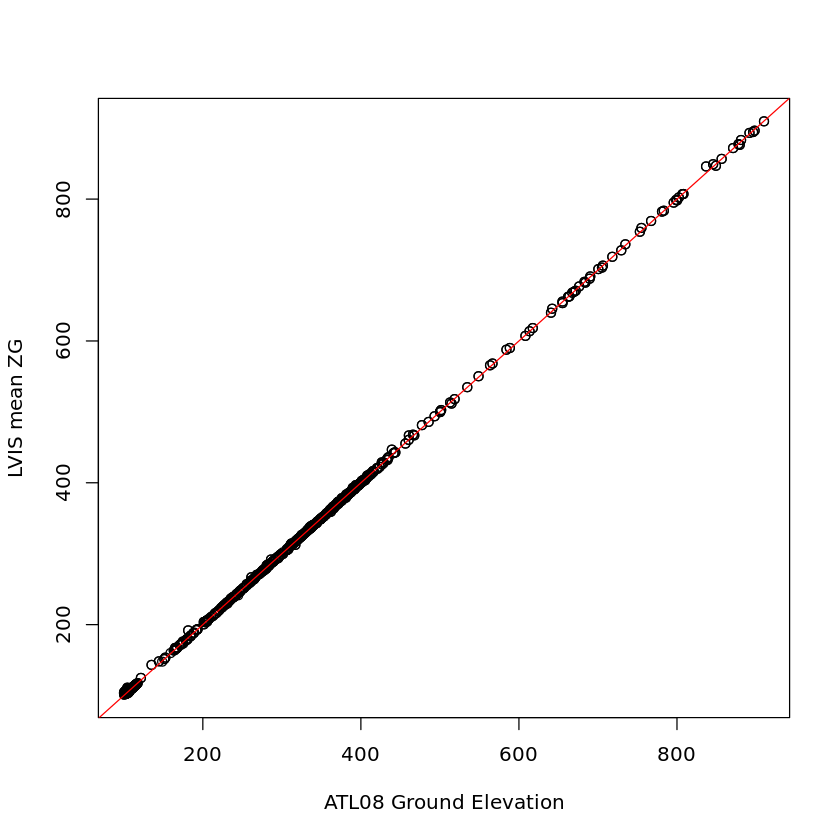

integer(0)

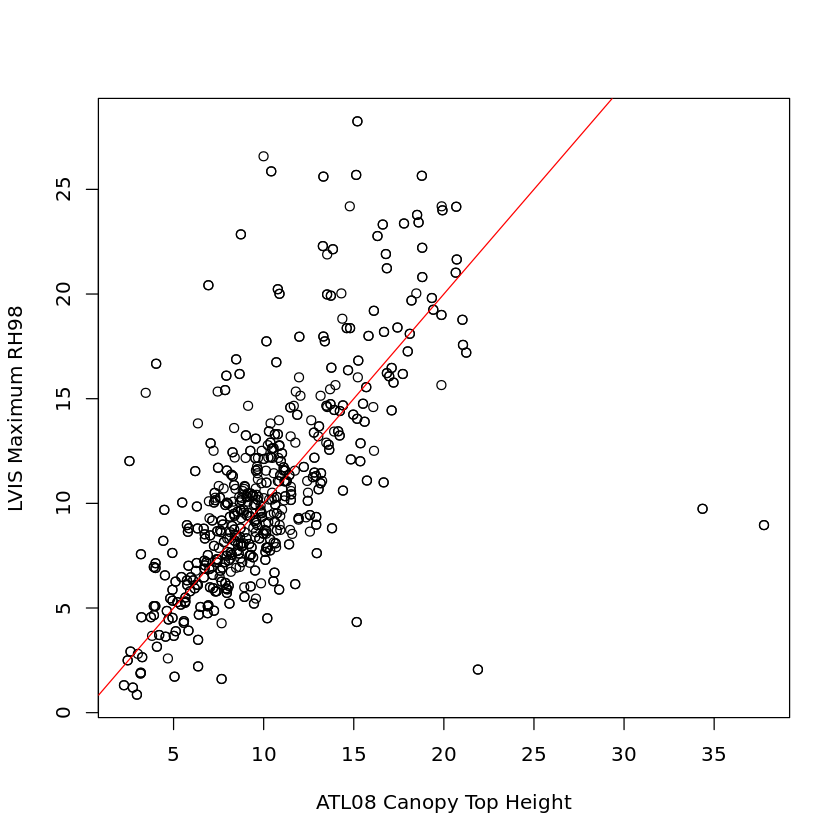

In [54]:
plot(ATL08_LVIS_table$`ATL08 Ground Elevation`,ATL08_LVIS_table$`LVIS mean ZG`,xlab="ATL08 Ground Elevation",ylab="LVIS mean ZG")+abline(a=0,b=1,col='red')
plot(ATL08_LVIS_table$`ATL08 Canopy Top Height`[which(ATL08_LVIS_table$cloud==0 & ATL08_LVIS_table$slope==0)],ATL08_LVIS_table$`LVIS Max RH98`[which(ATL08_LVIS_table$cloud==0)],xlab="ATL08 Canopy Top Height",ylab="LVIS Maximum RH98")+abline(a=0,b=1,col='red')